In [1]:
# Standard libraries
import xarray as xr
import numpy as np
import pandas as pd
# import os
# from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
import iris
from iris.pandas import as_cubes
import sys

from datetime import datetime
from cartopy.util import add_cyclic_point
import gc
import imageio.v2
from IPython import display
# import netCDF4
from global_land_mask import globe
# # Import tobac itself:
import tobac

# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

In [2]:
%%time
path = '/glade/u/home/noteng/work/research/data/'
file = 'march13-march14.nc'
data = xr.open_dataset(path+file)
data.close()

CPU times: user 21.4 ms, sys: 18.5 ms, total: 39.9 ms
Wall time: 726 ms


In [3]:
# equivalent_reflectivity_factor = data['equivalent_reflectivity_factor'][:,450:580,256:771] #Based on longitude and latitude of Andoya and Norwegian Sea
equivalent_reflectivity_factor = data['equivalent_reflectivity_factor'][:,250:650,450:850] #Based on longitude and latitude of Andoya and Norwegian Sea
# equivalent_reflectivity_factor = data['equivalent_reflectivity_factor'][:,330:580,660:780] #### hdm1 and hdm2
# equivalent_reflectivity_factor = data['equivalent_reflectivity_factor']
equivalent_reflectivity_factor

<xarray.DataArray 'equivalent_reflectivity_factor' (time: 360, Yc: 400, Xc: 400)>
[57600000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-03-13 ... 2020-03-14T05:55:00
  * Xc       (Xc) float32 -8.3e+04 -8.2e+04 -8.1e+04 ... 3.15e+05 3.16e+05
  * Yc       (Yc) float32 -2.06e+06 -2.061e+06 ... -2.458e+06 -2.459e+06
    lon      (Yc, Xc) float32 ...
    lat      (Yc, Xc) float32 ...
Attributes:
    standard_name:  equivalent_reflectivity_factor
    long_name:      Radar Reflectivity
    units:          dBZ
    grid_mapping:   projection_lambert

In [4]:
# load Mask_ERF_files
Mask_ERF = iris.load('../saved-files/threshold-10/Mask_ERF_iris-10.nc')[0]
Mask_ERF

<iris 'Cube' of segmentation_mask / (1) (time: 360; -- : 400; -- : 400)>

In [5]:
track = pd.read_csv('../saved-files/threshold-10/track-reset-10.csv')
track.sort_values(by=['timestr', 'time'],inplace=True)


In [11]:
distance = []
for i in range(len(track)):
    lat_andenes = 69.141281 # latitude of Andenes
    # lat_andenes = 69.2412 # latiude of the radar
    lon_andenes = 15.684166 # latitude of Andenes
    # lon_andenes = 16.0030 # longitude of where the radar is located

    
    distances = tobac.analysis.haversine(track['latitude'][i], track['longitude'][i], lat_andenes, lon_andenes)
    distance.append(distances)

In [12]:
distance[:10]

[152.05592193872158,
 149.57663480855493,
 137.89013242197237,
 132.13541793749116,
 125.95042766526436,
 127.68558353623716,
 76.85698850028963,
 74.28377764039793,
 72.32908811311259,
 120.8280610281261]

In [13]:
%%time
# apped distance to track dataframe
track['distance'] = pd.Series(distance)

CPU times: user 5.37 ms, sys: 0 ns, total: 5.37 ms
Wall time: 5.38 ms


In [14]:
track
# # 5km distance from the AMF1-site
# track = track[track['distance'] <= 20]
# track.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance
0,0,1,94.566045,308.115181,5,10,1,2020-03-13 00:00:00,2020-03-13 00:00:00,-2.154566e+06,225115.180751,70.503822,15.964784,1,0 days 00:00:00,152.055922
2,0,2,109.140243,299.415282,14,10,2,2020-03-13 00:00:00,2020-03-13 00:00:00,-2.169140e+06,216415.282348,70.379987,15.697549,2,0 days 00:00:00,137.890132
3,0,3,114.620052,324.589396,8,10,3,2020-03-13 00:00:00,2020-03-13 00:00:00,-2.174620e+06,241589.395814,70.306404,16.339280,3,0 days 00:00:00,132.135418
4,0,4,120.269461,312.957325,14,10,4,2020-03-13 00:00:00,2020-03-13 00:00:00,-2.180269e+06,229957.324986,70.266699,16.020838,4,0 days 00:00:00,125.950428
5,0,5,119.800236,294.978233,11,10,5,2020-03-13 00:00:00,2020-03-13 00:00:00,-2.179800e+06,211978.232992,70.287442,15.554357,5,0 days 00:00:00,127.685584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28935,359,12,165.743051,342.861606,3,10,28918,2020-03-14 05:55:00,2020-03-14 05:55:00,-2.225743e+06,259861.605934,69.825307,16.659290,10551,0 days 00:00:00,85.116370
28936,359,13,167.614825,212.629702,5,10,28919,2020-03-14 05:55:00,2020-03-14 05:55:00,-2.227615e+06,129629.702007,69.911593,13.330409,10552,0 days 00:00:00,125.490771
28937,359,25,260.000000,227.000000,1,10,28931,2020-03-14 05:55:00,2020-03-14 05:55:00,-2.320000e+06,144000.000000,69.063652,13.551733,10553,0 days 00:00:00,85.107024
28938,359,30,281.912697,319.134227,123,10,28936,2020-03-14 05:55:00,2020-03-14 05:55:00,-2.341913e+06,236134.226617,68.796278,15.757653,10554,0 days 00:00:00,38.516816


## _cells that lived for at least 10 mins old and less than 20 km long_  

In [13]:
# %%time
# # cell_one_hour = np.timedelta64( 600, 's') #10 minutes in seconds
# cell_times = np.timedelta64( 600, 's') #10 minutes in seconds

# #convert time_cell to seconds
# time_cell = track['time_cell'].astype('timedelta64[ns]').values

# # track cell that live for at least 10 minutes long
# track_close_to_AMF1 = track[ time_cell >= cell_times ]
# # track_close_to_AMF1 = track[ ((track['distance'] <= 95) & (track['time_cell'].values >= cell_one_hour)) ]
# track_close_to_AMF1= track_close_to_AMF1.drop_duplicates(subset=['cell']) # remove duplicates of cell_ids
# track_close_to_AMF1.head()

In [15]:
%%time
# cell_one_hour = np.timedelta64( 600, 's') #10 minutes in seconds
cell_times = np.timedelta64( 600, 's') #10 minutes in seconds

#convert time_cell to seconds
time_cell = track['time_cell'].astype('timedelta64[ns]').values

# track cell that live for at least 10 minutes long and was less than 20km
# track_close_to_AMF1 = track[ time_cell >= cell_times ]
track_close_to_AMF1 = track[ (time_cell >= cell_times) & (track['distance'] <= 20) ]
# # track_close_to_AMF1 = track[ ((track['distance'] <= 95) & (track['time_cell'].values >= cell_one_hour)) ]
track_close_to_AMF1= track_close_to_AMF1.drop_duplicates(subset=['cell']) # remove duplicates of cell_ids
track_close_to_AMF1.head()

CPU times: user 57.8 ms, sys: 565 µs, total: 58.4 ms
Wall time: 119 ms


,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance
1114,12,38,248.932895,300.520691,15,10,1212,2020-03-13 01:00:00,2020-03-13 01:00:00,-2.308933e+06,217520.691466,69.112041,15.381855,660,0 days 00:10:00,12.424376
2845,35,22,263.921037,314.261058,47,10,2906,2020-03-13 02:55:00,2020-03-13 02:55:00,-2.323921e+06,231261.058298,68.963957,15.682982,1513,0 days 00:10:00,19.739208
4042,49,36,230.085384,324.000000,2,10,4026,2020-03-13 04:05:00,2020-03-13 04:05:00,-2.290085e+06,241000.000000,69.261746,16.007481,2017,0 days 00:10:00,18.524025
4403,52,45,252.997935,318.049114,31,10,4345,2020-03-13 04:20:00,2020-03-13 04:20:00,-2.312998e+06,235049.113796,69.059589,15.802534,2161,0 days 00:10:00,10.236632
4407,52,46,260.955610,310.205639,54,10,4346,2020-03-13 04:20:00,2020-03-13 04:20:00,-2.320956e+06,227205.639278,68.994497,15.591049,2162,0 days 00:10:00,16.753948


In [16]:
# total track cells found.
len(track_close_to_AMF1) 

40

# tracking all cells that were at least 10 minutes old and less than 20km long back in time to get all the cells

In [17]:
%%time
combined_tracks_AMF1 = []
for index, cell_id in enumerate(np.unique(track_close_to_AMF1['cell'].values)): # looped through tracks found with AMF1 site
    if cell_id in track['cell']: # checking if those cells(tracks) are within the original tracked dataframe
        print(f'cell {cell_id} available')
        track_i = track[track['cell'] == cell_id] # display it if it is within the tracked dataframe
        combined_tracks_AMF1.append(track_i) # append the results you get a new dataFrame calld combined_tracks_AMF1

# Concatenate the dataframes(combined_tracks_AMD) along the rows axis with keys
# tracks_closer_AMF1 = pd.concat(combined_tracks_AMF1, keys=['df1', 'df2', 'df3', 'df4', 'df5', 'df6'])
tracks_closer_AMF1 = pd.concat(combined_tracks_AMF1)
tracks_closer_AMF1

cell 660 available
cell 1513 available
cell 2017 available
cell 2161 available
cell 2162 available
cell 2282 available
cell 2642 available
cell 4120 available
cell 4451 available
cell 4692 available
cell 4858 available
cell 5082 available
cell 5242 available
cell 5246 available
cell 5341 available
cell 5769 available
cell 5816 available
cell 6557 available
cell 7001 available
cell 7333 available
cell 7457 available
cell 7582 available
cell 7674 available
cell 7811 available
cell 7874 available
cell 8291 available
cell 8441 available
cell 8446 available
cell 8569 available
cell 8736 available
cell 8837 available
cell 9013 available
cell 9082 available
cell 9108 available
cell 9380 available
cell 9561 available
cell 9695 available
cell 10357 available
cell 10401 available
cell 10496 available
CPU times: user 15.7 ms, sys: 0 ns, total: 15.7 ms
Wall time: 15.7 ms


,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance
1112,10,33,240.428452,304.941520,3,10,1014,2020-03-13 00:50:00,2020-03-13 00:50:00,-2.300428e+06,221941.520162,69.185381,15.510746,660,0 days 00:00:00,8.441068
1113,11,27,243.838884,303.217736,9,10,1108,2020-03-13 00:55:00,2020-03-13 00:55:00,-2.303839e+06,220217.735914,69.155943,15.460159,660,0 days 00:05:00,9.024574
1114,12,38,248.932895,300.520691,15,10,1212,2020-03-13 01:00:00,2020-03-13 01:00:00,-2.308933e+06,217520.691466,69.112041,15.381855,660,0 days 00:10:00,12.424376
1115,13,27,253.897567,297.347887,21,10,1297,2020-03-13 01:05:00,2020-03-13 01:05:00,-2.313898e+06,214347.886523,69.069669,15.292490,660,0 days 00:15:00,17.474204
1116,14,35,257.525864,296.472916,15,10,1387,2020-03-13 01:10:00,2020-03-13 01:10:00,-2.317526e+06,213472.915609,69.037465,15.262802,660,0 days 00:20:00,20.342258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28574,349,27,259.108897,325.977229,72,10,28557,2020-03-14 05:05:00,2020-03-14 05:05:00,-2.319109e+06,242977.228605,68.996753,15.981160,10401,0 days 00:30:00,19.958188
28833,354,20,223.000000,299.983268,3,10,28732,2020-03-14 05:30:00,2020-03-14 05:30:00,-2.283000e+06,216983.268198,69.347793,15.429257,10496,0 days 00:00:00,25.091391
28834,355,20,223.928103,302.748563,9,10,28769,2020-03-14 05:35:00,2020-03-14 05:35:00,-2.283928e+06,219748.562602,69.336976,15.495807,10496,0 days 00:05:00,23.017195
28835,356,24,225.348055,305.335314,3,10,28810,2020-03-14 05:40:00,2020-03-14 05:40:00,-2.285348e+06,222335.313832,69.321826,15.556664,10496,0 days 00:10:00,20.718299


In [18]:
# track_close_to_AMF1 = track_close_to_AMF1.sort_values(by=['timestr', 'time'])
# track_close_to_AMF1

In [19]:
# resetting the index

tracks_closer_AMF1_index_reset = tracks_closer_AMF1.reset_index(drop=True)
tracks_closer_AMF1_index_reset.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance
0,10,33,240.428452,304.941520,3,10,1014,2020-03-13 00:50:00,2020-03-13 00:50:00,-2.300428e+06,221941.520162,69.185381,15.510746,660,0 days 00:00:00,8.441068
1,11,27,243.838884,303.217736,9,10,1108,2020-03-13 00:55:00,2020-03-13 00:55:00,-2.303839e+06,220217.735914,69.155943,15.460159,660,0 days 00:05:00,9.024574
2,12,38,248.932895,300.520691,15,10,1212,2020-03-13 01:00:00,2020-03-13 01:00:00,-2.308933e+06,217520.691466,69.112041,15.381855,660,0 days 00:10:00,12.424376
3,13,27,253.897567,297.347887,21,10,1297,2020-03-13 01:05:00,2020-03-13 01:05:00,-2.313898e+06,214347.886523,69.069669,15.292490,660,0 days 00:15:00,17.474204
4,14,35,257.525864,296.472916,15,10,1387,2020-03-13 01:10:00,2020-03-13 01:10:00,-2.317526e+06,213472.915609,69.037465,15.262802,660,0 days 00:20:00,20.342258


# Algorithm to calculate the corresponding reflectivity values (calculate for the max and mean dBZ) and the area

In [20]:
unique_cell_ids = track_close_to_AMF1['cell'].values # getting the cells_tracked
len(unique_cell_ids)

40

In [21]:
%%time
# all masked cell in iris cube
masked_tracked_cell = []
for i, unique_value in enumerate(unique_cell_ids):
    # get masked cell based on cell id
    get_mask_cell = tobac.utils.mask_cell(mask=Mask_ERF, cell=unique_value, track=track, masked=False) 
    masked_tracked_cell.append(get_mask_cell)

CPU times: user 99.4 ms, sys: 3.91 ms, total: 103 ms
Wall time: 185 ms


In [22]:
masked_tracked_cell[:10]

[<iris 'Cube' of segmentation_mask / (1) (time: 360; -- : 400; -- : 400)>,
 <iris 'Cube' of segmentation_mask / (1) (time: 360; -- : 400; -- : 400)>,
 <iris 'Cube' of segmentation_mask / (1) (time: 360; -- : 400; -- : 400)>,
 <iris 'Cube' of segmentation_mask / (1) (time: 360; -- : 400; -- : 400)>,
 <iris 'Cube' of segmentation_mask / (1) (time: 360; -- : 400; -- : 400)>,
 <iris 'Cube' of segmentation_mask / (1) (time: 360; -- : 400; -- : 400)>,
 <iris 'Cube' of segmentation_mask / (1) (time: 360; -- : 400; -- : 400)>,
 <iris 'Cube' of segmentation_mask / (1) (time: 360; -- : 400; -- : 400)>,
 <iris 'Cube' of segmentation_mask / (1) (time: 360; -- : 400; -- : 400)>,
 <iris 'Cube' of segmentation_mask / (1) (time: 360; -- : 400; -- : 400)>]

In [24]:
%%time
# Convert the segmented/mask cells from iris cube to xrray
masked_values_to_xarray = []
for i, items in enumerate(masked_tracked_cell):
    mask_convert_xr = xr.DataArray.from_iris(masked_tracked_cell[i]) # convert iris cube to xarray data array
    masked_values_to_xarray.append(mask_convert_xr) # append the results to list
    # print(mask_convert_xr)

CPU times: user 78.3 ms, sys: 0 ns, total: 78.3 ms
Wall time: 78.3 ms


In [25]:
%%time
# Getting the original masked reflectivity values
slice_cell_times = []
for i, cell_id in enumerate(np.unique(tracks_closer_AMF1['cell'])):
    cell_ids = tracks_closer_AMF1_index_reset[tracks_closer_AMF1_index_reset['cell'] == cell_id] 
    first_time = cell_ids['timestr'][::].values[0] # get first time (start time)
    last_time = cell_ids['timestr'][::-1].values[0]  # get the last time value (end time)
    # slice values based on time
    slice_cell_time = masked_values_to_xarray[i].sel(time=slice(first_time, last_time))
    slice_cell_times.append(slice_cell_time)
    # print(slice_cell_time)

CPU times: user 61.8 ms, sys: 2.99 ms, total: 64.8 ms
Wall time: 284 ms


In [26]:
%%time
equivalent_reflectivity_factors = 10**((equivalent_reflectivity_factor/10))
# equivalent_reflectivity_factors = 10*np.log10(Z)

CPU times: user 4.99 s, sys: 265 ms, total: 5.25 s
Wall time: 5.62 s


## algorithm to extract the speed, area, maximum, minimum and mean reflectivity values based on cell_id and specific times

In [27]:
%%time
min_reflectivities = []; mean_reflectivities = []; max_reflectivities = []; areas = [];
for i, cell_id in enumerate(np.unique(tracks_closer_AMF1['cell'])):
    #################################
    import warnings
    warnings.filterwarnings('ignore')
    #################################
    cell_ids = tracks_closer_AMF1_index_reset[tracks_closer_AMF1_index_reset['cell'] == cell_id]  # dataframe based on cell_id
    first_time = cell_ids['timestr'][::].values[0] # get first time (start time)
    last_time = cell_ids['timestr'][::-1].values[0]  # get the last time value (end time)
    
#     # # # # Calculating area
    # area = tobac.analysis.calculate_area(track, Mask_ERF)
#     # area = tobac.analysis.calculate_area(cell_ids, masked_tracked_cell[i], method_area=None)
#     area = np.absolute(area['area']/1000000) # area in kilometers
#     areas.append(area)
    
    # area1 = np.divide(area['area'],1000000)
    # area['area($km^2$)'] = area1


    # reflectivity_masked based on times
    reflectivity_masked = equivalent_reflectivity_factors.sel(time=slice(first_time, last_time))
    
    # LOOPING THROUGH THE AND GETTING THE VALUES
    for index in (range(len(reflectivity_masked))):
        mean_ref = reflectivity_masked[index].mean().item() # get mean values of reflectivity # in dBZ values
        # # Convert from dBZ to Z values
        # mean_ref_Z = 10**(mean_ref / 10)
        # # Convert it back to dBZ units
        # mean_ref_dBZ = 10*np.log10(mean_ref_Z)
        #####################################
        max_ref = reflectivity_masked[index].max().item() # get max values of reflectivity
        
        mean_reflectivities.append(mean_ref)
        max_reflectivities.append(max_ref)
        
# concatenate the area values to one series
# area1 = pd.concat(areas)

# calculate velocity
# velocity = tobac.analysis.calculate_velocity(tracks_closer_AMF1_index_reset)

CPU times: user 383 ms, sys: 926 µs, total: 384 ms
Wall time: 388 ms


In [28]:
# converting the mean Z unit back to dBZ
mean_reflectivities1 = 10*np.log10(mean_reflectivities)

# converting the max Z unit back to dBZ
max_reflectivities1 = 10*np.log10(max_reflectivities)

In [29]:
np.min(mean_reflectivities1), np.max(mean_reflectivities1)

(12.268499706178087, 17.00984974968715)

In [30]:
tracks_closer_AMF1_index_reset

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance
0,10,33,240.428452,304.941520,3,10,1014,2020-03-13 00:50:00,2020-03-13 00:50:00,-2.300428e+06,221941.520162,69.185381,15.510746,660,0 days 00:00:00,8.441068
1,11,27,243.838884,303.217736,9,10,1108,2020-03-13 00:55:00,2020-03-13 00:55:00,-2.303839e+06,220217.735914,69.155943,15.460159,660,0 days 00:05:00,9.024574
2,12,38,248.932895,300.520691,15,10,1212,2020-03-13 01:00:00,2020-03-13 01:00:00,-2.308933e+06,217520.691466,69.112041,15.381855,660,0 days 00:10:00,12.424376
3,13,27,253.897567,297.347887,21,10,1297,2020-03-13 01:05:00,2020-03-13 01:05:00,-2.313898e+06,214347.886523,69.069669,15.292490,660,0 days 00:15:00,17.474204
4,14,35,257.525864,296.472916,15,10,1387,2020-03-13 01:10:00,2020-03-13 01:10:00,-2.317526e+06,213472.915609,69.037465,15.262802,660,0 days 00:20:00,20.342258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,349,27,259.108897,325.977229,72,10,28557,2020-03-14 05:05:00,2020-03-14 05:05:00,-2.319109e+06,242977.228605,68.996753,15.981160,10401,0 days 00:30:00,19.958188
220,354,20,223.000000,299.983268,3,10,28732,2020-03-14 05:30:00,2020-03-14 05:30:00,-2.283000e+06,216983.268198,69.347793,15.429257,10496,0 days 00:00:00,25.091391
221,355,20,223.928103,302.748563,9,10,28769,2020-03-14 05:35:00,2020-03-14 05:35:00,-2.283928e+06,219748.562602,69.336976,15.495807,10496,0 days 00:05:00,23.017195
222,356,24,225.348055,305.335314,3,10,28810,2020-03-14 05:40:00,2020-03-14 05:40:00,-2.285348e+06,222335.313832,69.321826,15.556664,10496,0 days 00:10:00,20.718299


In [31]:
# append max min and mean reflectivity values based on each cell id and times to the tracks_closer_AMF1_index_reset dataframe
# tracks_closer_AMF1_index_reset['speed'] = velocity
# tracks_closer_AMF1_index_reset['area1'] = area1
tracks_closer_AMF1_index_reset['mean dBZ'] = pd.Series(mean_reflectivities1)
tracks_closer_AMF1_index_reset['max dBZ'] = pd.Series(max_reflectivities1)

In [32]:
tracks_closer_AMF1_index_reset

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance,mean dBZ,max dBZ
0,10,33,240.428452,304.941520,3,10,1014,2020-03-13 00:50:00,2020-03-13 00:50:00,-2.300428e+06,221941.520162,69.185381,15.510746,660,0 days 00:00:00,8.441068,14.058102,37.085349
1,11,27,243.838884,303.217736,9,10,1108,2020-03-13 00:55:00,2020-03-13 00:55:00,-2.303839e+06,220217.735914,69.155943,15.460159,660,0 days 00:05:00,9.024574,14.142291,37.591586
2,12,38,248.932895,300.520691,15,10,1212,2020-03-13 01:00:00,2020-03-13 01:00:00,-2.308933e+06,217520.691466,69.112041,15.381855,660,0 days 00:10:00,12.424376,14.152186,34.567482
3,13,27,253.897567,297.347887,21,10,1297,2020-03-13 01:05:00,2020-03-13 01:05:00,-2.313898e+06,214347.886523,69.069669,15.292490,660,0 days 00:15:00,17.474204,13.920004,37.591586
4,14,35,257.525864,296.472916,15,10,1387,2020-03-13 01:10:00,2020-03-13 01:10:00,-2.317526e+06,213472.915609,69.037465,15.262802,660,0 days 00:20:00,20.342258,13.719391,35.071053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,349,27,259.108897,325.977229,72,10,28557,2020-03-14 05:05:00,2020-03-14 05:05:00,-2.319109e+06,242977.228605,68.996753,15.981160,10401,0 days 00:30:00,19.958188,14.067273,37.088039
220,354,20,223.000000,299.983268,3,10,28732,2020-03-14 05:30:00,2020-03-14 05:30:00,-2.283000e+06,216983.268198,69.347793,15.429257,10496,0 days 00:00:00,25.091391,13.921129,38.092506
221,355,20,223.928103,302.748563,9,10,28769,2020-03-14 05:35:00,2020-03-14 05:35:00,-2.283928e+06,219748.562602,69.336976,15.495807,10496,0 days 00:05:00,23.017195,14.172154,38.598690
222,356,24,225.348055,305.335314,3,10,28810,2020-03-14 05:40:00,2020-03-14 05:40:00,-2.285348e+06,222335.313832,69.321826,15.556664,10496,0 days 00:10:00,20.718299,15.070454,40.610380


In [33]:
len(tracks_closer_AMF1_index_reset)

224

## _CALCULATE AREA_

In [35]:
area = tobac.calculate_area(tracks_closer_AMF1_index_reset, Mask_ERF, method_area=None)
# area1 = (c['area']/1000000)
area1 = np.divide(area['area'],1000000)
area['area($km^2$)'] = area1

In [36]:
tracks_closer_AMF1_index_reset

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance,mean dBZ,max dBZ,area,area($km^2$)
0,10,33,240.428452,304.941520,3,10,1014,2020-03-13 00:50:00,2020-03-13 00:50:00,-2.300428e+06,221941.520162,69.185381,15.510746,660,0 days 00:00:00,8.441068,14.058102,37.085349,4.974739e+07,49.747395
1,11,27,243.838884,303.217736,9,10,1108,2020-03-13 00:55:00,2020-03-13 00:55:00,-2.303839e+06,220217.735914,69.155943,15.460159,660,0 days 00:05:00,9.024574,14.142291,37.591586,9.949878e+07,99.498779
2,12,38,248.932895,300.520691,15,10,1212,2020-03-13 01:00:00,2020-03-13 01:00:00,-2.308933e+06,217520.691466,69.112041,15.381855,660,0 days 00:10:00,12.424376,14.152186,34.567482,NaN,NaN
3,13,27,253.897567,297.347887,21,10,1297,2020-03-13 01:05:00,2020-03-13 01:05:00,-2.313898e+06,214347.886523,69.069669,15.292490,660,0 days 00:15:00,17.474204,13.920004,37.591586,7.263401e+07,72.634011
4,14,35,257.525864,296.472916,15,10,1387,2020-03-13 01:10:00,2020-03-13 01:10:00,-2.317526e+06,213472.915609,69.037465,15.262802,660,0 days 00:20:00,20.342258,13.719391,35.071053,6.567052e+07,65.670517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,349,27,259.108897,325.977229,72,10,28557,2020-03-14 05:05:00,2020-03-14 05:05:00,-2.319109e+06,242977.228605,68.996753,15.981160,10401,0 days 00:30:00,19.958188,14.067273,37.088039,1.412915e+08,141.291473
220,354,20,223.000000,299.983268,3,10,28732,2020-03-14 05:30:00,2020-03-14 05:30:00,-2.283000e+06,216983.268198,69.347793,15.429257,10496,0 days 00:00:00,25.091391,13.921129,38.092506,9.451884e+07,94.518842
221,355,20,223.928103,302.748563,9,10,28769,2020-03-14 05:35:00,2020-03-14 05:35:00,-2.283928e+06,219748.562602,69.336976,15.495807,10496,0 days 00:05:00,23.017195,14.172154,38.598690,9.953243e+05,0.995324
222,356,24,225.348055,305.335314,3,10,28810,2020-03-14 05:40:00,2020-03-14 05:40:00,-2.285348e+06,222335.313832,69.321826,15.556664,10496,0 days 00:10:00,20.718299,15.070454,40.610380,1.154153e+08,115.415271


In [37]:
final_tracks_thresh_10 = tracks_closer_AMF1_index_reset.drop(columns=['area'])
final_tracks_thresh_10 = final_tracks_thresh_10.sort_values(by=['timestr', 'time'])
final_tracks_thresh_10

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance,mean dBZ,max dBZ,area($km^2$)
0,10,33,240.428452,304.941520,3,10,1014,2020-03-13 00:50:00,2020-03-13 00:50:00,-2.300428e+06,221941.520162,69.185381,15.510746,660,0 days 00:00:00,8.441068,14.058102,37.085349,49.747395
1,11,27,243.838884,303.217736,9,10,1108,2020-03-13 00:55:00,2020-03-13 00:55:00,-2.303839e+06,220217.735914,69.155943,15.460159,660,0 days 00:05:00,9.024574,14.142291,37.591586,99.498779
2,12,38,248.932895,300.520691,15,10,1212,2020-03-13 01:00:00,2020-03-13 01:00:00,-2.308933e+06,217520.691466,69.112041,15.381855,660,0 days 00:10:00,12.424376,14.152186,34.567482,NaN
3,13,27,253.897567,297.347887,21,10,1297,2020-03-13 01:05:00,2020-03-13 01:05:00,-2.313898e+06,214347.886523,69.069669,15.292490,660,0 days 00:15:00,17.474204,13.920004,37.591586,72.634011
4,14,35,257.525864,296.472916,15,10,1387,2020-03-13 01:10:00,2020-03-13 01:10:00,-2.317526e+06,213472.915609,69.037465,15.262802,660,0 days 00:20:00,20.342258,13.719391,35.071053,65.670517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,349,27,259.108897,325.977229,72,10,28557,2020-03-14 05:05:00,2020-03-14 05:05:00,-2.319109e+06,242977.228605,68.996753,15.981160,10401,0 days 00:30:00,19.958188,14.067273,37.088039,141.291473
220,354,20,223.000000,299.983268,3,10,28732,2020-03-14 05:30:00,2020-03-14 05:30:00,-2.283000e+06,216983.268198,69.347793,15.429257,10496,0 days 00:00:00,25.091391,13.921129,38.092506,94.518842
221,355,20,223.928103,302.748563,9,10,28769,2020-03-14 05:35:00,2020-03-14 05:35:00,-2.283928e+06,219748.562602,69.336976,15.495807,10496,0 days 00:05:00,23.017195,14.172154,38.598690,0.995324
222,356,24,225.348055,305.335314,3,10,28810,2020-03-14 05:40:00,2020-03-14 05:40:00,-2.285348e+06,222335.313832,69.321826,15.556664,10496,0 days 00:10:00,20.718299,15.070454,40.610380,115.415271


In [42]:
tracks = final_tracks_thresh_10.copy()
tracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance,mean dBZ,max dBZ,area($km^2$)
0,10,33,240.428452,304.941520,3,10,1014,2020-03-13 00:50:00,2020-03-13 00:50:00,-2.300428e+06,221941.520162,69.185381,15.510746,660,0 days 00:00:00,8.441068,14.058102,37.085349,49.747395
1,11,27,243.838884,303.217736,9,10,1108,2020-03-13 00:55:00,2020-03-13 00:55:00,-2.303839e+06,220217.735914,69.155943,15.460159,660,0 days 00:05:00,9.024574,14.142291,37.591586,99.498779
2,12,38,248.932895,300.520691,15,10,1212,2020-03-13 01:00:00,2020-03-13 01:00:00,-2.308933e+06,217520.691466,69.112041,15.381855,660,0 days 00:10:00,12.424376,14.152186,34.567482,NaN
3,13,27,253.897567,297.347887,21,10,1297,2020-03-13 01:05:00,2020-03-13 01:05:00,-2.313898e+06,214347.886523,69.069669,15.292490,660,0 days 00:15:00,17.474204,13.920004,37.591586,72.634011
4,14,35,257.525864,296.472916,15,10,1387,2020-03-13 01:10:00,2020-03-13 01:10:00,-2.317526e+06,213472.915609,69.037465,15.262802,660,0 days 00:20:00,20.342258,13.719391,35.071053,65.670517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,349,27,259.108897,325.977229,72,10,28557,2020-03-14 05:05:00,2020-03-14 05:05:00,-2.319109e+06,242977.228605,68.996753,15.981160,10401,0 days 00:30:00,19.958188,14.067273,37.088039,141.291473
220,354,20,223.000000,299.983268,3,10,28732,2020-03-14 05:30:00,2020-03-14 05:30:00,-2.283000e+06,216983.268198,69.347793,15.429257,10496,0 days 00:00:00,25.091391,13.921129,38.092506,94.518842
221,355,20,223.928103,302.748563,9,10,28769,2020-03-14 05:35:00,2020-03-14 05:35:00,-2.283928e+06,219748.562602,69.336976,15.495807,10496,0 days 00:05:00,23.017195,14.172154,38.598690,0.995324
222,356,24,225.348055,305.335314,3,10,28810,2020-03-14 05:40:00,2020-03-14 05:40:00,-2.285348e+06,222335.313832,69.321826,15.556664,10496,0 days 00:10:00,20.718299,15.070454,40.610380,115.415271


In [33]:
# all tracks
# final_tracks_thresh_10.to_csv('../cells-closer-to-AMF1/saved-files/cells-closer-AMF1_20km-thres-10.csv', index=False)

In [44]:
# tracks = pd.read_csv('./saved-files/cells-closer-AMF1_20km-thres-10.csv')
# tracks.head()

In [50]:
len(tracks)

224

In [51]:
v = tracks[tracks['cell'] == 7001]
v

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance,mean dBZ,max dBZ,area($km^2$)
87,182,35,227.758509,323.517556,297,10,17862,2020-03-13 15:10:00,2020-03-13 15:10:00,-2.287759e+06,240517.556444,69.283289,16.001596,7001,0 days 00:00:00,20.178146,17.009850,43.631830,751.204801
88,183,38,229.963904,326.212359,283,10,17936,2020-03-13 15:15:00,2020-03-13 15:15:00,-2.289964e+06,243212.358596,69.260720,16.062539,7001,0 days 00:05:00,20.011479,16.791765,43.130650,809.902417
89,184,34,234.518880,328.335971,309,10,18003,2020-03-13 15:20:00,2020-03-13 15:20:00,-2.294519e+06,245335.971084,69.217394,16.103028,7001,0 days 00:10:00,18.613237,16.247956,40.106802,NaN


## _PROOF THAT WE HAVE AREA OF THIS KIND_

In [52]:
mask_cell_660 = tobac.utils.mask_cell(Mask_ERF, 7001, tracks)
mask_cell_660

<iris 'Cube' of segmentation_mask / (1) (time: 360; -- : 400; -- : 400)>

In [53]:
convert_660 = xr.DataArray.from_iris(mask_cell_660)
convert_660

<xarray.DataArray 'segmentation_mask' (time: 360, dim_1: 400, dim_2: 400)>
[57600000 values with dtype=int32]
Coordinates:
  * time     (time) datetime64[ns] 2020-03-13 ... 2020-03-14T05:55:00
    lat      (dim_1, dim_2) float32 ...
    lon      (dim_1, dim_2) float32 ...
Dimensions without coordinates: dim_1, dim_2
Attributes:
    long_name:    segmentation_mask
    Conventions:  CF-1.7

In [80]:
# for i, j in enumerate(tracks['frame'].values):
#     print(i, j)

In [82]:
tracks['frame'].values[87:89+1]

array([182, 183, 184])

In [98]:
vv = tracks[tracks['cell'] == 7001]
vv

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance,mean dBZ,max dBZ,area($km^2$)
87,182,35,227.758509,323.517556,297,10,17862,2020-03-13 15:10:00,2020-03-13 15:10:00,-2.287759e+06,240517.556444,69.283289,16.001596,7001,0 days 00:00:00,20.178146,17.009850,43.631830,751.204801
88,183,38,229.963904,326.212359,283,10,17936,2020-03-13 15:15:00,2020-03-13 15:15:00,-2.289964e+06,243212.358596,69.260720,16.062539,7001,0 days 00:05:00,20.011479,16.791765,43.130650,809.902417
89,184,34,234.518880,328.335971,309,10,18003,2020-03-13 15:20:00,2020-03-13 15:20:00,-2.294519e+06,245335.971084,69.217394,16.103028,7001,0 days 00:10:00,18.613237,16.247956,40.106802,NaN


In [123]:
vvs = tracks[tracks['frame'] == 182]
vvs

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance,mean dBZ,max dBZ,area($km^2$)
87,182,35,227.758509,323.517556,297,10,17862,2020-03-13 15:10:00,2020-03-13 15:10:00,-2.287759e+06,240517.556444,69.283289,16.001596,7001,0 days 00:00:00,20.178146,17.00985,43.63183,751.204801


In [169]:
# %%time

# for i in range(182, 184+1):
for idx, i in enumerate(tracks['frame'].values[87:89+1]):
# for i in range(0, 20+1):

    ## center points and extent of map ###
    latA = 69.141281 #latitude of COMBLE site
    lonA = 15.684166-1 #longitude of COMBLE site -1
    xm, ym = 6,2.75 # extent from center point in lon and lat

    fig, ax = plt.subplots(1,1,figsize=(10,9),subplot_kw={'projection': ccrs.Orthographic(lonA,latA)})

    extent = (lonA-xm, lonA+xm, latA-ym, latA+ym) # define extent map
    ax.set_extent(extent) # set extent of map
    ax.coastlines(resolution='10m', color='grey') # plot coastlines with high resolution: 10m
    ax.set_facecolor('black')


    #change time to moth, day, year, hours and minutes
    dt = masked_values_to_xarray[1]['time'].dt.strftime('%m-%d-%Y %H:%M').values  ### array 
    # dt = convert['time'].dt.strftime('%m-%d-%Y %H:%M').values  ### array 
    

#     #     # fill in the place where there is cloud with 1 and place with no cloud to be zero
    cloud = np.asarray(convert_660[i], dtype='float')
    # print(type(cloud))
    invalid_cloud = np.greater(cloud,0)
    cloud[invalid_cloud] = 1
    invalid_cloud1 = np.less(cloud,1)
    cloud[invalid_cloud1] = np.nan
    

    cs=ax.pcolormesh(convert_660['lon'],
                convert_660['lat'], 
                # cloud*equivalent_reflectivity_factor.values[i],
                cloud*equivalent_reflectivity_factor.values[i],
                cmap='jet',
                transform=ccrs.PlateCarree(),
                vmin=-20,
                vmax=40
                )
    g=tracks[tracks['frame']==i]
    longi = g['longitude'].values[0]
    lati = g['latitude'].values[0]
    print(g['cell'].values[0])
    # print(g['longitude'].values[0])
    fontdict={'fontweight': 'extra bold'}
    ax.text(longi, lati+0.1, g['cell'].values[0], transform=ccrs.PlateCarree(), fontsize=13, color='white', fontdict=fontdict)

   

    ax.plot(lonA+1,latA, color='red', marker='*', markersize = 10.5,transform=ccrs.PlateCarree()) # plot red star at location of Andenes
    # ax.plot(lonA,latA, color='red', marker='*', markersize = 20.5,transform=ccrs.PlateCarree()) # plot red star at location of Andenes
    ax.set_title(f"Nordic Radar Mosaic: {dt[i]} UTC", fontweight='bold', fontsize=16, pad=11)  # title of figure


    # Add a colorbar axis at the right of the graph
    cbar_ax = fig.add_axes([0.85, 0.13, 0.047, 0.75]) #lbwh


    cbar=fig.colorbar(cs, cax=cbar_ax, orientation='vertical')
    cbar.set_label("Reflectivity Factor [dBZ]", fontsize = 15)
    
    fig.savefig(f'./big//{dt[i]}.png', dpi=100)
    plt.close()



# #     dirr = sorted(os.listdir('./mod-images//'))
# #     if f'{dt[i]}.png' in dirr:
# #         # print(f'{dt[i]}.png already exist')
# #         pass
# #         plt.close()
# #     else:
# #         fig.savefig(f'./mod-images//{dt[i]}.png', dpi=100)
# #         plt.close()
# print('\U0001f600\U0001f600\U0001f600\U0001f600EXECUTION DONE!!!\U0001f600\U0001f600\U0001f600\U0001f600')
# gc.collect()

7001
7001
7001


# for all cells

In [155]:
idx = np.unique(tracks['cell'].values)
idx

array([  660,  1513,  2017,  2161,  2162,  2282,  2642,  4120,  4451,
        4692,  4858,  5082,  5242,  5246,  5341,  5769,  5816,  6557,
        7001,  7333,  7457,  7582,  7674,  7811,  7874,  8291,  8441,
        8446,  8569,  8736,  8837,  9013,  9082,  9108,  9380,  9561,
        9695, 10357, 10401, 10496])

In [156]:
len(masked_values_to_xarray)
# for i in tracks['frame']:
#     print(i)

40

In [157]:
s = tracks[tracks['cell'] == 2642]
s

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance,mean dBZ,max dBZ,area($km^2$)
31,61,45,234.178999,321.140954,27,10,5359,2020-03-13 05:05:00,2020-03-13 05:05:00,-2.294179e+06,238140.954072,69.227347,15.926207,2642,0 days 00:00:00,13.544836,12.806260,35.073834,32.834241
32,62,40,238.316814,322.734521,17,10,5478,2020-03-13 05:10:00,2020-03-13 05:10:00,-2.298317e+06,239734.521499,69.188335,15.954915,2642,0 days 00:05:00,11.931118,12.854479,35.071053,27.858541
33,63,46,240.298140,324.168688,15,10,5603,2020-03-13 05:15:00,2020-03-13 05:15:00,-2.300298e+06,241168.688480,69.169012,15.985159,2642,0 days 00:10:00,12.315737,13.039496,38.095143,24.875129
34,64,49,243.662361,326.132517,14,10,5731,2020-03-13 05:20:00,2020-03-13 05:20:00,-2.303662e+06,243132.516898,69.136646,16.024792,2642,0 days 00:15:00,13.512358,13.214808,38.092506,26.864267
35,65,48,246.249140,326.992503,9,10,5859,2020-03-13 05:25:00,2020-03-13 05:25:00,-2.306249e+06,243992.503048,69.112373,16.039213,2642,0 days 00:20:00,14.444985,13.442471,39.102244,33.829272


In [158]:
convert_alls = []
for ii, v in enumerate(idx):
    # mask in iris cube
    mask_cell_all = tobac.utils.mask_cell(Mask_ERF, v, tracks)
    # convert to xarray dataarray
    convert_all = xr.DataArray.from_iris(mask_cell_all)
    convert_alls.append(convert_all)

In [159]:
convert_660

<xarray.DataArray 'segmentation_mask' (time: 360, dim_1: 400, dim_2: 400)>
[57600000 values with dtype=int32]
Coordinates:
  * time     (time) datetime64[ns] 2020-03-13 ... 2020-03-14T05:55:00
    lat      (dim_1, dim_2) float32 ...
    lon      (dim_1, dim_2) float32 ...
Dimensions without coordinates: dim_1, dim_2
Attributes:
    long_name:    segmentation_mask
    Conventions:  CF-1.7

In [160]:
convert_alls[39]

<xarray.DataArray 'segmentation_mask' (time: 360, dim_1: 400, dim_2: 400)>
[57600000 values with dtype=int32]
Coordinates:
  * time     (time) datetime64[ns] 2020-03-13 ... 2020-03-14T05:55:00
    lat      (dim_1, dim_2) float32 ...
    lon      (dim_1, dim_2) float32 ...
Dimensions without coordinates: dim_1, dim_2
Attributes:
    long_name:    segmentation_mask
    Conventions:  CF-1.7

In [161]:
# masked_values_to_xarray[39]

In [162]:
# # %%time

# for i in range(10, 18+1):
# # for i in range(0, 20+1):

#     ## center points and extent of map ###
#     latA = 69.141281 #latitude of COMBLE site
#     lonA = 15.684166-1 #longitude of COMBLE site -1
#     xm, ym = 6,2.75 # extent from center point in lon and lat

#     fig, ax = plt.subplots(1,1,figsize=(10,9),subplot_kw={'projection': ccrs.Orthographic(lonA,latA)})

#     extent = (lonA-xm, lonA+xm, latA-ym, latA+ym) # define extent map
#     ax.set_extent(extent) # set extent of map
#     ax.coastlines(resolution='10m') # plot coastlines with high resolution: 10m


    
    
    
#     #change time to moth, day, year, hours and minutes
#     dt = masked_values_to_xarray[1]['time'].dt.strftime('%m-%d-%Y %H:%M').values  ### array 
#     # dt = convert['time'].dt.strftime('%m-%d-%Y %H:%M').values  ### array 
    

# #     #     # fill in the place where there is cloud with 1 and place with no cloud to be zero
#     # cloud = np.asarray(convert_660[i], dtype='float')
#     cloud = np.asarray(convert_alls[0][i], dtype='float')
#     invalid_cloud = np.greater(cloud,0)
#     cloud[invalid_cloud] = 1
#     invalid_cloud1 = np.less(cloud,1)
#     cloud[invalid_cloud1] = np.nan
    

#     cs=ax.pcolormesh(convert_alls[0]['lon'],
#                 convert_alls[0]['lat'], 
#                 # cloud*equivalent_reflectivity_factor.values[i],
#                 cloud*equivalent_reflectivity_factor.values[i],
#                 cmap='jet',
#                 transform=ccrs.PlateCarree(),
#                 vmin=-20,
#                 vmax=40
#                 )

#     ax.plot(lonA+1,latA, color='red', marker='*', markersize = 10.5,transform=ccrs.PlateCarree()) # plot red star at location of Andenes
#     # ax.plot(lonA,latA, color='red', marker='*', markersize = 20.5,transform=ccrs.PlateCarree()) # plot red star at location of Andenes
#     ax.set_title(f"Nordic Radar Mosaic: {dt[i]} UTC", fontweight='bold', fontsize=16, pad=11)  # title of figure


#     # Add a colorbar axis at the right of the graph
#     cbar_ax = fig.add_axes([0.85, 0.13, 0.047, 0.75]) #lbwh


#     cbar=fig.colorbar(cs, cax=cbar_ax, orientation='vertical')
#     cbar.set_label("Reflectivity Factor [dBZ]", fontsize = 15)
    
#     fig.savefig(f'./bb//{dt[i]}.png', dpi=100)
#     plt.close()



# # #     dirr = sorted(os.listdir('./mod-images//'))
# # #     if f'{dt[i]}.png' in dirr:
# # #         # print(f'{dt[i]}.png already exist')
# # #         pass
# # #         plt.close()
# # #     else:
# # #         fig.savefig(f'./mod-images//{dt[i]}.png', dpi=100)
# # #         plt.close()
# # print('\U0001f600\U0001f600\U0001f600\U0001f600EXECUTION DONE!!!\U0001f600\U0001f600\U0001f600\U0001f600')
# # gc.collect()

In [170]:
# %%time

# for i in range(10, 18+1):
for i in tracks['frame'].values[:35]:
# for i in range(0, 20+1):

    ## center points and extent of map ###
    latA = 69.141281 #latitude of COMBLE site
    lonA = 15.684166-1 #longitude of COMBLE site -1
    xm, ym = 6,2.75 # extent from center point in lon and lat

    fig, ax = plt.subplots(1,1,figsize=(10,9),subplot_kw={'projection': ccrs.Orthographic(lonA,latA)})

    extent = (lonA-xm, lonA+xm, latA-ym, latA+ym) # define extent map
    ax.set_extent(extent) # set extent of map
    ax.coastlines(resolution='10m', color='grey') # plot coastlines with high resolution: 10m
    ax.set_facecolor('black')
    
    

    #############################
    for j in range(0, 40):
    
        #change time to moth, day, year, hours and minutes
        dt = masked_values_to_xarray[j]['time'].dt.strftime('%m-%d-%Y %H:%M').values  ### array 
        # dt = convert['time'].dt.strftime('%m-%d-%Y %H:%M').values  ### array 


    #     #     # fill in the place where there is cloud with 1 and place with no cloud to be zero
        # cloud = np.asarray(convert_660[i], dtype='float')
        cloud = np.asarray(convert_alls[j][i], dtype='float')
        invalid_cloud = np.greater(cloud,0)
        cloud[invalid_cloud] = 1
        invalid_cloud1 = np.less(cloud,1)
        cloud[invalid_cloud1] = np.nan
        
        # g=tracks[tracks['frame']==i]
        # longi = g['longitude'].values[0]
        # lati = g['latitude'].values[0]
        # print(g['cell'].values[0])
        # # print(g['longitude'].values[0])
        # ax.text(longi, lati+0.1, g['cell'].values[0], transform=ccrs.PlateCarree(), fontsize=20, color='white')

    

        cs=ax.pcolormesh(convert_alls[j]['lon'],
                    convert_alls[j]['lat'], 
                    # cloud*equivalent_reflectivity_factor.values[i],
                    cloud*equivalent_reflectivity_factor.values[i],
                    cmap='jet',
                    transform=ccrs.PlateCarree(),
                    vmin=-20,
                    vmax=40
                    )
        
    g=tracks[tracks['frame']==i]
    longi = g['longitude'].values[0]
    lati = g['latitude'].values[0]
    print(g['cell'].values[0])
    fontdict={'fontweight': 'extra bold'}
    ax.text(longi, lati+0.1, g['cell'].values[0], transform=ccrs.PlateCarree(), fontsize=13, color='white', fontdict=fontdict)


    ax.plot(lonA+1,latA, color='red', marker='*', markersize = 10.5,transform=ccrs.PlateCarree()) # plot red star at location of Andenes
    # ax.plot(lonA,latA, color='red', marker='*', markersize = 20.5,transform=ccrs.PlateCarree()) # plot red star at location of Andenes
    ax.set_title(f"Nordic Radar Mosaic: {dt[i]} UTC", fontweight='bold', fontsize=16, pad=11)  # title of figure


    # Add a colorbar axis at the right of the graph
    cbar_ax = fig.add_axes([0.85, 0.13, 0.047, 0.75]) #lbwh


    cbar=fig.colorbar(cs, cax=cbar_ax, orientation='vertical')
    cbar.set_label("Reflectivity Factor [dBZ]", fontsize = 15)
    
    fig.savefig(f'./bb//frame{i}: {dt[i]}.png', dpi=100)
    plt.close()

660
660
660
660
660
660
660
660
660
1513
1513
1513
1513
1513
2017
2017
2017
2161
2161
2161
2161
2161
2161
2161
2161
2161
2282
2282
2282
2282
2282
2642
2642
2642
2642


In [175]:
%%time
import glob
# Build GIF
imgs = sorted(glob.glob("./bb/*.png"))
with imageio.get_writer('large-area.gif', mode='I', duration=0.5) as writer:
    for filename in imgs:
        image = imageio.v2.imread(filename)
        writer.append_data(image)

CPU times: user 2.23 s, sys: 5.12 ms, total: 2.24 s
Wall time: 2.35 s


CPU times: user 0 ns, sys: 480 µs, total: 480 µs
Wall time: 485 µs


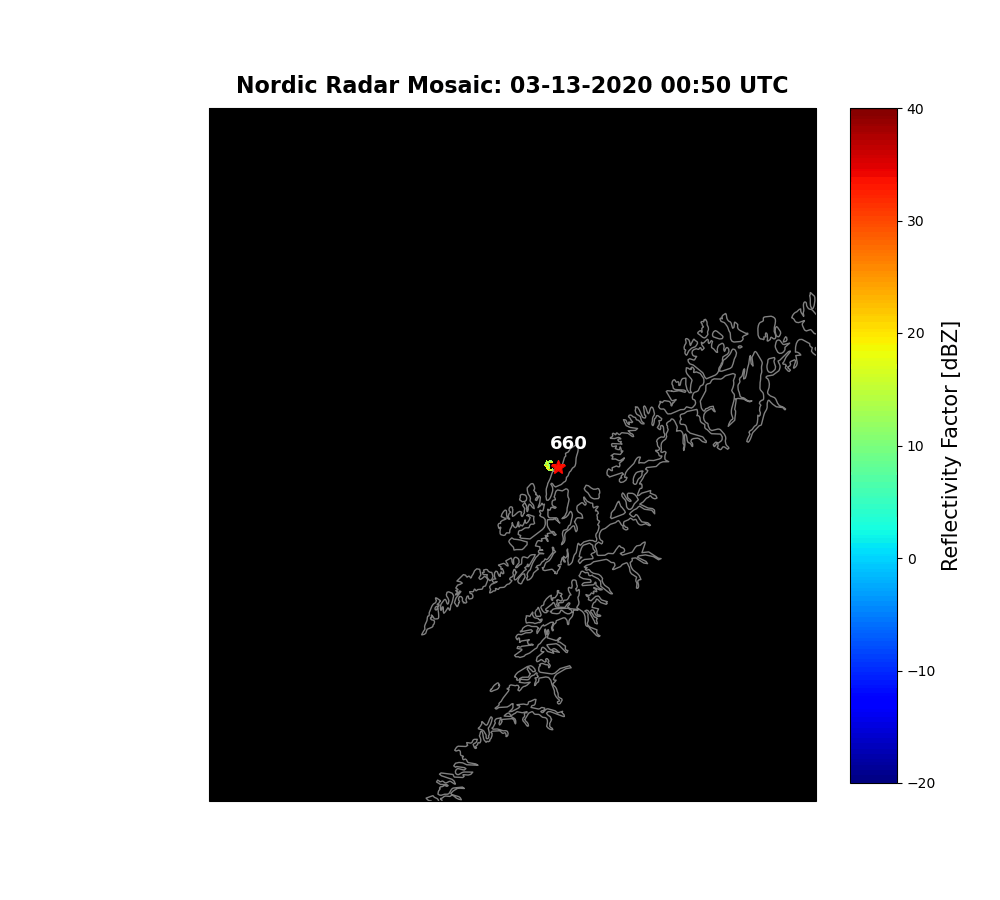

In [176]:
%%time
#Display image
display.Image('large-area.gif', width=700)

In [ ]:


# for i in tracks['frame'].values:
for i in tracks['frame'].values[:14]:
# for i in range(0, 20+1):

    ## center points and extent of map ###
    latA = 69.141281 #latitude of COMBLE site
    lonA = 15.684166-1 #longitude of COMBLE site -1
    xm, ym = 6,2.75 # extent from center point in lon and lat

    fig, ax = plt.subplots(1,1,figsize=(10,9),subplot_kw={'projection': ccrs.Orthographic(lonA,latA)})

    extent = (lonA-xm, lonA+xm, latA-ym, latA+ym) # define extent map
    ax.set_extent(extent) # set extent of map
    ax.coastlines(resolution='10m') # plot coastlines with high resolution: 10m


    #change time to moth, day, year, hours and minutes
    dt = masked_values_to_xarray[i]['time'].dt.strftime('%m-%d-%Y %H:%M').values  ### array 
    # dt = convert['time'].dt.strftime('%m-%d-%Y %H:%M').values  ### array 


#     #     # fill in the place where there is cloud with 1 and place with no cloud to be zero
    cloud = np.asarray(convert_all[i], dtype='float')
    invalid_cloud = np.greater(cloud,0)
    cloud[invalid_cloud] = 1
    invalid_cloud1 = np.less(cloud,1)
    cloud[invalid_cloud1] = np.nan


    # cs=ax.pcolormesh(convert_all['lon'],
    #             convert_all['lat'], 
    #             # cloud*equivalent_reflectivity_factor.values[i],
    #             cloud*equivalent_reflectivity_factor.values[i],
    #             cmap='jet',
    #             transform=ccrs.PlateCarree(),
    #             vmin=-20,
    #             vmax=40
    #             )
    
    cs=ax.pcolormesh(convert_all['lon'],
                convert_all['lat'], 
                # cloud*equivalent_reflectivity_factor.values[i],
                cloud*equivalent_reflectivity_factor.values[i],
                cmap='jet',
                transform=ccrs.PlateCarree(),
                vmin=-20,
                vmax=40
                )

    ax.plot(lonA+1,latA, color='red', marker='*', markersize = 10.5,transform=ccrs.PlateCarree()) # plot red star at location of Andenes
    # ax.plot(lonA,latA, color='red', marker='*', markersize = 20.5,transform=ccrs.PlateCarree()) # plot red star at location of Andenes
    ax.set_title(f"Nordic Radar Mosaic: {dt[i]} UTC", fontweight='bold', fontsize=16, pad=11)  # title of figure


    # Add a colorbar axis at the right of the graph
    cbar_ax = fig.add_axes([0.85, 0.13, 0.047, 0.75]) #lbwh


    cbar=fig.colorbar(cs, cax=cbar_ax, orientation='vertical')
    cbar.set_label("Reflectivity Factor [dBZ]", fontsize = 15)

    fig.savefig(f'./news//{dt[i]}--{v}.png', dpi=100)
    plt.close()



# #     dirr = sorted(os.listdir('./mod-images//'))
# #     if f'{dt[i]}.png' in dirr:
# #         # print(f'{dt[i]}.png already exist')
# #         pass
# #         plt.close()
# #     else:
# #         fig.savefig(f'./mod-images//{dt[i]}.png', dpi=100)
# #         plt.close()
# print('\U0001f600\U0001f600\U0001f600\U0001f600EXECUTION DONE!!!\U0001f600\U0001f600\U0001f600\U0001f600')
# gc.collect()